In [1]:
pip install pymannkendall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly,add_changepoints_to_plot

In [5]:
df = pd.read_excel("/content/Airlines+Data.xlsx")
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [7]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [8]:
df.set_index("Month", inplace=True)

In [9]:
fig = px.line(df)
fig.show()

### Mann-Kendall Test to detect Trend

#### Hypothesis :
H0 : There is no Trend

H1 : There is Trend

In [10]:
mk.original_test(df)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=11.16793132276346, Tau=0.7739035087719298, s=3529.0, var_s=99795.66666666667, slope=2.2142857142857144, intercept=94.82142857142857)

#### Conclusion :
The p-value is less than 0.05, hence we reject H0 and conclude that the the trend is present in the data.

### Augmented Dickey-fuller Test for Stationarity detection

#### Hypothesis:
H0 : The data is non-stationary

H1 : The data is stationary

In [11]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.340248
p-value: 0.996825


#### Conclusion :

The p-value is more than 0.05, hence we do not reject H0 and conclude that the data is non-stationary.


### Using Seasonal Decomposition to find the type of model

In [12]:
types = ["additive", "multiplicative"]
for i in types:
    seasonal_decomposition = seasonal_decompose(df, model = i , period=12)
    seasonal_decomposition_fig = seasonal_decomposition.plot()
    seasonal_decomposition_fig = plotly.tools.mpl_to_plotly(seasonal_decomposition_fig)
    seasonal_decomposition_fig.update_layout(width = 800, height = 700, title = i)
    seasonal_decomposition_fig.show()
    print("\n\n")

#### Conclusion :
For the Additive model, the residuals have a huge standard deviation, and also show a distinct pattern that an additive model didn’t capture. On the other hand, for the multiplicative model, the residuals are now centered around 1 and have a much lower range and standard deviation. Hence, our data follows a multiplicative model

## Finding the order of differencing

In [13]:
data = df
for i in range(1,20):
    series = data.diff()
    series = series.dropna()
    result = adfuller(series)
    p_value = result[1]
    data = series
    if p_value < 0.05:
        print("The order of which the data becomes stationary is : ",i)
        fig = px.line(data)
        fig.show()
        break  

The order of which the data becomes stationary is :  2


Here, the graph shows that at the 2nd order differencing, the data becomes stationary and the trend is also gone, but to validate our results, we shall also perform the statistical test for testing stationarity and trend.

### 1. Mann-Kendall Test to detect Trend

#### Hypothesis :
H0 : There is no Trend

H1 : There is Trend

In [14]:
mk.original_test(data)

Mann_Kendall_Test(trend='no trend', h=False, p=0.9713246636384092, z=-0.035946944624701355, Tau=-0.002745367192862045, s=-12.0, var_s=93640.0, slope=0.0, intercept=-1.0)

Conclusion :
The p-value is more than 0.05, hence we do not reject H0 and conclude that the the trend is not present in the data.

### 2. Augmented Dickey-fuller Test for Stationarity detection

#### Hypothesis:
H0 : The data is non-stationary

H1 : The data is stationary

In [15]:
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.547981
p-value: 0.000000


#### Conclusion :

The p-value is less than 0.05, hence we reject H0 and conclude that the data is stationary.


## ACF and PACF plots

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



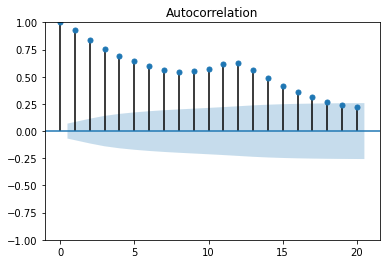

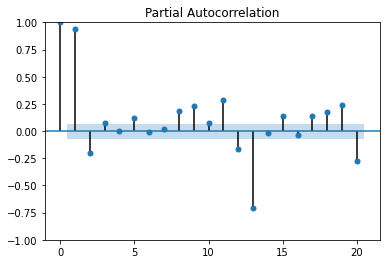

In [16]:
acf = smt.graphics.plot_acf(df, lags=20, alpha=0.5)
acf.show()
pacf = smt.graphics.plot_pacf(df, lags=20, alpha=0.5)
pacf.show()

## Using ARIMA for model building

In [17]:
model = ARIMA(df['Passengers'],order = (2,2,0))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                   96
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -441.261
Date:                Thu, 05 Jan 2023   AIC                            888.522
Time:                        13:40:51   BIC                            896.152
Sample:                    01-01-1995   HQIC                           891.604
                         - 12-01-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2922      0.110     -2.645      0.008      -0.509      -0.076
ar.L2         -0.3195      0.121     -2.642      0.008      -0.556      -0.082
sigma2       697.7279     93.264      7.481      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



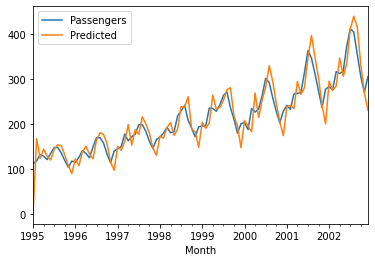

In [18]:
pred = model.predict()
df.plot(legend=True)
pred.plot(label="Predicted",legend=True)

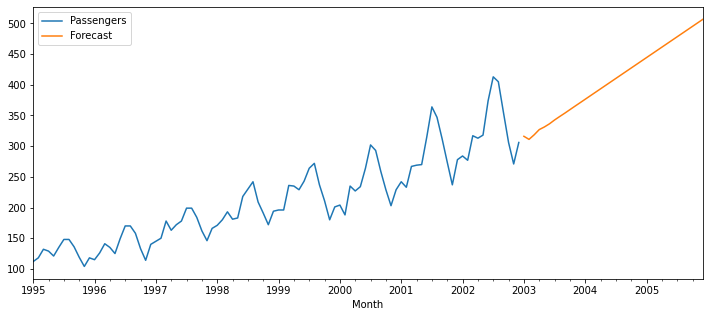

In [19]:
# Actual vs Fitted
forecast = model.predict(start = len(df), 
                          end = (len(df)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')
# Plot the forecast values

df['Passengers'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [20]:
error = np.sqrt(mean_squared_error(df["Passengers"],pred))
print('Test RMSE: %.4f' % error)

Test RMSE: 28.9873


### In - Sample Forecasting :

In [21]:
train = df["Passengers"].iloc[:-30]
test = df["Passengers"].iloc[-30:]
print(train.shape , test.shape, df.shape)

(66,) (30,) (96, 1)


In [22]:
print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(10,2,0))
    model_fit = model.fit()
    
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    print('predicted = %f, expected = %f' % (yhat, obs))


	 ARIMA MODEL : In- Sample Forecasting 

predicted = 267.756583, expected = 302.000000
predicted = 307.685319, expected = 293.000000
predicted = 283.483224, expected = 259.000000
predicted = 253.189959, expected = 229.000000
predicted = 214.611597, expected = 203.000000
predicted = 213.526796, expected = 229.000000
predicted = 228.139034, expected = 242.000000
predicted = 264.040112, expected = 233.000000
predicted = 221.171775, expected = 267.000000
predicted = 280.949678, expected = 269.000000
predicted = 274.833168, expected = 270.000000
predicted = 289.491661, expected = 315.000000
predicted = 326.635692, expected = 364.000000
predicted = 367.371688, expected = 347.000000
predicted = 334.497077, expected = 312.000000
predicted = 301.672634, expected = 274.000000
predicted = 258.195454, expected = 237.000000
predicted = 245.709749, expected = 278.000000
predicted = 300.183615, expected = 284.000000
predicted = 284.975304, expected = 277.000000
predicted = 279.771493, expected = 317.

In [23]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   95
Model:                ARIMA(10, 2, 0)   Log Likelihood                -406.875
Date:                Thu, 05 Jan 2023   AIC                            835.751
Time:                        13:41:02   BIC                            863.609
Sample:                             0   HQIC                           846.999
                                 - 95                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4589      0.112     -4.092      0.000      -0.679      -0.239
ar.L2         -0.6973      0.112     -6.201      0.000      -0.918      -0.477
ar.L3         -0.3920      0.112     -3.498      0.0

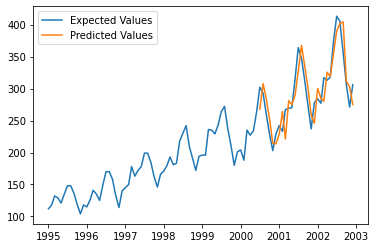

In [24]:
predictions_series = pd.Series(predictions, index = test.index)
# fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

# plt.subplot(1,1,1)
plt.plot(df['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [25]:
#Calculate mean squared error
print("MSE : ",mean_squared_error(test, predictions))
  
# Calculate root mean squared error
print("RMSE : ",rmse(test, predictions))

MSE :  626.8628880441796
RMSE :  25.037230039366968


### Making Predictions for future dates

In [26]:
index_future_dates = pd.date_range(start='2003-01-01', periods=12, freq='M')
fut_pred = model_fit.predict(start=len(df), end=len(df)+12, typ="levels")
fut_val = fut_pred[-12:]
fut_fc = pd.DataFrame({'Passengers' : fut_val},index=index_future_dates)
fut_fc

,Passengers
2003-01-31,288.836338
2003-02-28,295.514859
2003-03-31,283.176516
2003-04-30,303.836052
2003-05-31,333.281761
2003-06-30,345.635759
2003-07-31,330.068454
2003-08-31,300.842944
2003-09-30,269.230789
2003-10-31,255.297127


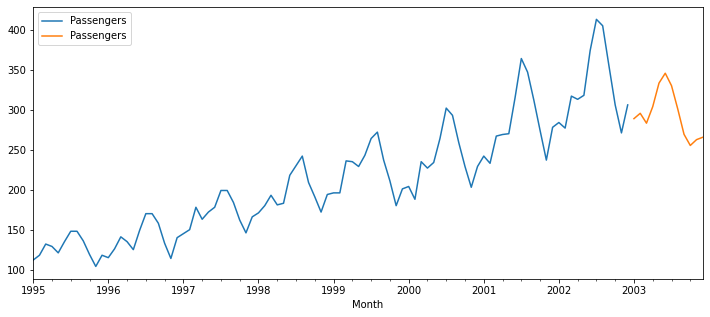

In [27]:
df['Passengers'].plot(figsize = (12, 5), legend = True)
fut_fc["Passengers"].plot(legend = True)

## Using Auto ARIMA for model building

Here, in our data there is a serious problem of seasonality, hence we shall use SARIMAX model for forecasting. For that purpose we shall use Auto ARIMA.

In [28]:
auto_arima_model = auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # periodicity=4
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=619.334, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=622.012, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=615.965, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=616.628, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=618.192, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=617.814, Time=0.51 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=617.881, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=616.531, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.06 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=618.221, Time=0.09 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=617.862, Time=0.18 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=617.462, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=616.076, Time=0.14 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=619.394, Time=0.44 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

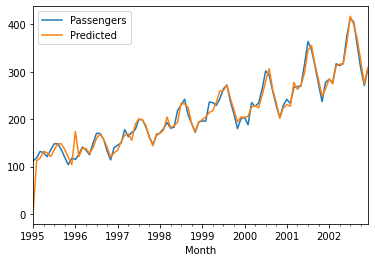

In [29]:
# making predictions
pred_auto = auto_arima_model.predict_in_sample(df)
df.plot(legend=True)
pred_auto.plot(label="Predicted",legend=True)
plt.show()

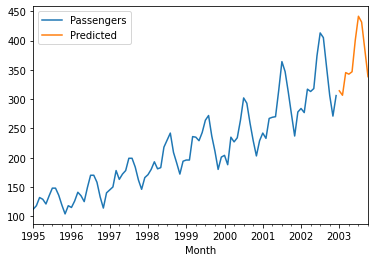

In [30]:
# making future predictions
fut_pred_auto = auto_arima_model.predict(n_periods=10)
df.plot(legend=True)
fut_pred_auto.plot(label="Predicted",legend=True)
plt.show()

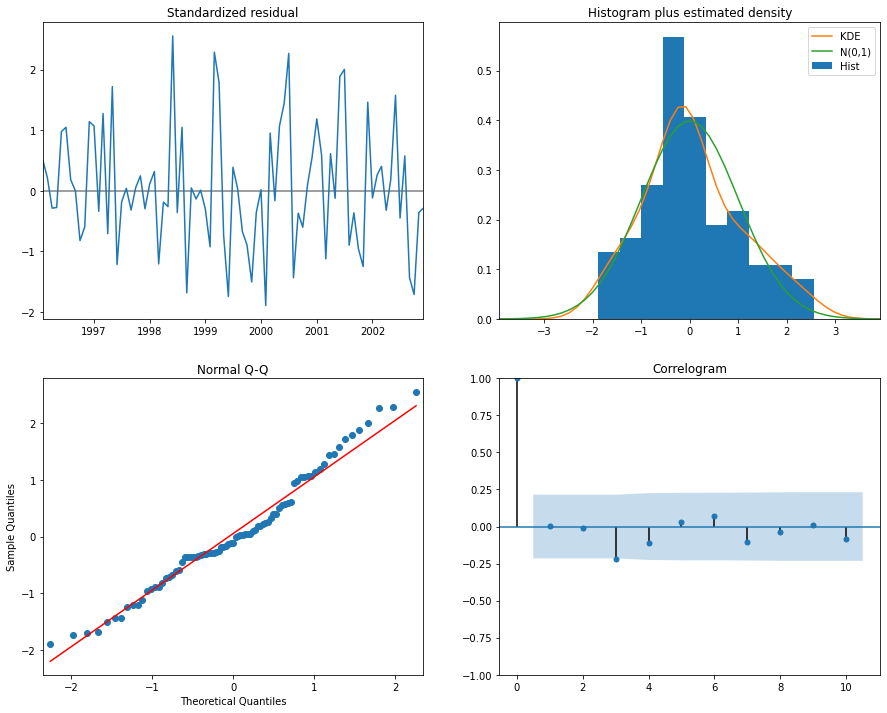

In [31]:
auto_arima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

## Using FB Prophet for building the forecasting model

In [32]:
data1 = df.reset_index()

In [33]:
train_dataset= pd.DataFrame()
train_dataset['ds'] = data1['Month']
train_dataset['y']= data1['Passengers']

In [34]:
m = Prophet()
m.fit(train_dataset)
future = m.make_future_dataframe(periods=14, freq='MS')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ws6bxe1/xaim8wqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ws6bxe1/71qb90iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43223', 'data', 'file=/tmp/tmp6ws6bxe1/xaim8wqp.json', 'init=/tmp/tmp6ws6bxe1/71qb90iw.json', 'output', 'file=/tmp/tmp6ws6bxe1/prophet_model3s5itdu9/prophet_model-20230105134110.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,1995-01-01,93.047369,77.314669,109.490845
1,1995-02-01,91.857989,75.364169,108.100482
2,1995-03-01,124.543183,108.211094,140.917002
3,1995-04-01,119.880127,104.716861,137.220453
4,1995-05-01,116.894670,100.599645,132.715088
...,...,...,...,...
105,2003-10-01,361.485855,345.285685,378.269953
106,2003-11-01,338.076766,321.795695,354.641911
107,2003-12-01,360.330712,344.172744,376.815212
108,2004-01-01,367.900087,351.829161,383.730734


In [35]:
plot_plotly(m , forecast)

In [36]:
plot_components_plotly(m,forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ws6bxe1/a3f28onl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6ws6bxe1/fkvvay3l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3651', 'data', 'file=/tmp/tmp6ws6bxe1/a3f28onl.json', 'init=/tmp/tmp6ws6bxe1/fkvvay3l.json', 'output', 'file=/tmp/tmp6ws6bxe1/prophet_model3mktc8v1/prophet_model-20230105134111.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:41:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


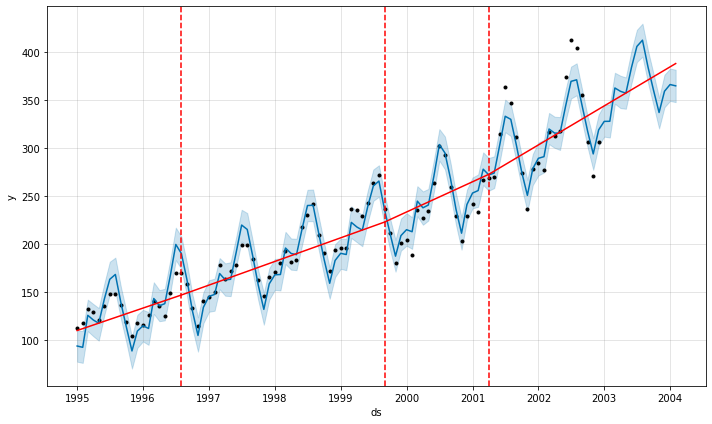

In [37]:
pro_change= Prophet(n_changepoints=4)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)